# Competition 3
We apply bag of words technique on single word and bigrams, in addition to text feature extraction, to predict whether customers are satisfied using product reviews. We fitted with lasso and ridge regularisation methods for automatic feature selection.

In [1]:
## Importing packages

suppressMessages(library(tidyverse)) # metapackage with lots of helpful functions
suppressMessages(library(tidytext))
suppressMessages(library(Matrix))

## Data attached to this notebook

list.files(path = "../input")

options(warn=-1) # Don't show warning messages 
options(dplyr.summarise.inform = FALSE) #Stop dplyr show summarise information


[1] "bda2022amazon"            "bda2022amazon-sample-csv"

# 1. The project

In this competition you will predict customer sentiments regarding [Baby products purchased on Amazon.com](http://jmcauley.ucsd.edu/data/amazon/), on the basis of their written reviews. 

Answer the 3 most important questions for any ML project:

1. Where do the data come from? (To which population will results generalize?)
2. What are candidate machine learning methods? (models? features?)
3. What is the Bayes' error bound?


<div style=color:darkblue;background-color:#fafaff;min-height:8em; >


1. the data come from amazon and generalises to people who would leave reviews for amazon purchases 
    
2. linear and non linear classification models (mutlinomial logistic regression etc), features could be single word frequency features, ngram features 

3. The bayes error bound is probably quite high. In reviews people often give high or low rating (1 or 5 stars) and thus it would be enough to get the overal tendency of a review to predict if the consumer was satisfied or not. 

</div>

# 2. Read Data

Locate and load the data into memory.

In [2]:
dir("../input", recursive=TRUE)

[1] "bda2022amazon-sample-csv/sample.csv"         
[2] "bda2022amazon/amazon_baby_testset_sample.csv"
[3] "bda2022amazon/amazon_baby.csv"

In [3]:
# Find the right file path
csv_filepath = dir("..", pattern="amazon_baby.csv", recursive=TRUE, full.names = TRUE)

# Read in the csv file
amazon = read_csv(csv_filepath) %>%
    rownames_to_column('id') 

# inspect df
head(amazon) 

Rows: 183531 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, review
dbl (1): rating

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,name,review,rating
<chr>,<chr>,<chr>,<dbl>
1,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion not worth keeping. I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality. I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.",3
2,Planetwise Wipe Pouch,it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.,5
3,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,NA
4,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"This is a product well worth the purchase. I have not found anything else like this, and it is a positive, ingenious approach to losing the binky. What I love most about this product is how much ownership my daughter has in getting rid of the binky. She is so proud of herself, and loves her little fairy. I love the artwork, the chart in the back, and the clever approach of this tool.",5
5,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love\'s Binky Fairy Puppet. It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!! You will save them soo many headaches.Thanks for this book! You all rock!!",NA
6,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"When the Binky Fairy came to our house, we didn\'t have any special gift and book to help explain to her about how important it is to stop using a pacifier. This book does a great job to help prepare your child for the loss of their favorite item. The doll is adorable and we made lots of cute movies with the Binky Fairy telling our daughter about what happens when the Binky Fairy comes. I would highly recommend this product for any parent trying to break the pacifier or thumb sucking habit.",5


The data frame contains both the train and test data. The test data are the reviews for which the rating is missing and you need to provide a prediction. 

The following logical index variable will be of help selecting the desired rows without the need to split the data frame into seperate sets. This makes it easier to extract features.

In [4]:
trainidx = !is.na(amazon$rating)
table(trainidx)

trainidx
 FALSE   TRUE 
 30000 153531 

From the above, there are 153,531 training samples and 30,000 test samples.

# 3. Preprocessing

The table contains, the product `name`, the textual `review`, and the `rating`. We paste `name` and `review` using the `unite()` function:

In [5]:
# Paste name and review into a single string separated by a "–".
# The new string replaces the original review.
all_df = amazon %>% 
    unite(review, name, review, sep = " — ", remove = FALSE)

print(all_df)

# A tibble: 183,531 × 4
   id    review                                                     name  rating
   <chr> <chr>                                                      <chr>  <dbl>
 1 1     "Planetwise Flannel Wipes — These flannel wipes are OK, b… "Pla…      3
 2 2     "Planetwise Wipe Pouch — it came early and was not disapp… "Pla…      5
 3 3     "Annas Dream Full Quilt with 2 Shams — Very soft and comf… "Ann…     NA
 4 4     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto…      5
 5 5     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto…     NA
 6 6     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto…      5
 7 7     "A Tale of Baby\\'s Days with Peter Rabbit — Lovely book,… "A T…      4
 8 8     "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab…     NA
 9 9     "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab…      5
10 10    "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab…      4
# … 

In [6]:
# create train set that is used for fitting and cv 
train_df = all_df[trainidx, ]
dim(train_df)

[1] 153531      4

In [7]:
# get test set 
testidx = is.na(amazon$rating)
test_df = all_df[testidx, ]
dim(test_df)
head(test_df)

[1] 30000     4

id,review,name,rating
<chr>,<chr>,<chr>,<dbl>
3,Annas Dream Full Quilt with 2 Shams — Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,Annas Dream Full Quilt with 2 Shams,NA
5,"Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book — All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love\'s Binky Fairy Puppet. It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!! You will save them soo many headaches.Thanks for this book! You all rock!!",Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,NA
8,"Baby Tracker&reg; - Daily Childcare Journal, Schedule Log — Perfect for new parents. We were able to keep track of baby\'s feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!","Baby Tracker&reg; - Daily Childcare Journal, Schedule Log",NA
14,"Baby Tracker&reg; - Daily Childcare Journal, Schedule Log — I thought keeping a simple handwritten journal would be nice. But I haven\'t used this thing at all, and here\'s why:1.) When you\'re breastfeeding, it\'s often nice to have your phone close by so that you can keep yourself entertained. If you are able to grab *both* your phone and this notebook - and a pen - consistently - and at 3 in the morning - you are more skilled than me. (I don\'t nurse in the same place every time.)2.) You\'re also often so sleep deprived that - at least for me - I\'d forget to look at what time we started on a side, or what side we started on. I\'m not perfect with the app I have either, but at least I just have to mindlessly hit a button.3.) I really like the app I have (Baby Connect). It gives me better data. For example, it can tell me how long on average feedings have been taking (helpful as we start to think about sleep training). It can tell me that I nursed him 177 times last month (granted that serves no useful purpose other than a feeling of perverse satisfaction).","Baby Tracker&reg; - Daily Childcare Journal, Schedule Log",NA
20,Nature\'s Lullabies Second Year Sticker Calendar — We wanted to get something to keep track of our child\'s milestones and this is a cute option. There aren\'t many other choices out there and this does exactly what we wanted.,Nature\'s Lullabies Second Year Sticker Calendar,NA
22,"Nature\'s Lullabies Second Year Sticker Calendar — I only purchased a second-year calendar for my son because I had one for my daughter. I was really disappointed with the lack of selection available for second-year calendars in general, so I just got this one because it was one of the only ones. It\'s an okay calendar. The finish on the pages is glossy which makes it hard to write on with certain pens. The stickers aren\'t very cute and the pages are pretty old-fashioned looking. Hopefully they will come out with some other calendars for future purchasers.",Nature\'s Lullabies Second Year Sticker Calendar,NA


## 3.1 Tokenization into single words

We're going to use tidytext to break up the text into separate tokens and count the number of occurences per review. To keep track of the review to which the review belongs, we have added the rownames as `id` above, which is simply the row number. As tokens you can consider single words, pairs of words called bi-grams, or n-grams. 

In [8]:
# sample some training data and combine with all test observations 
sample = train_df %>%
    sample_n(dim(train_df)[1]*0.6) %>% # take only 60% of all training data because otherwise the notebook crashes
    rbind(test_df)

reviews = sample %>% 

   # tokinize reviews at word level
   unnest_tokens(token, review) %>%

   # count tokens within reviews as 'n'
   # (keep id, name, and rating in the result)
   count(id, name, rating, token)

head(reviews)

id,name,rating,token,n
<chr>,<chr>,<dbl>,<chr>,<int>
1,Planetwise Flannel Wipes,3,12,1
1,Planetwise Flannel Wipes,3,6,1
1,Planetwise Flannel Wipes,3,8,1
1,Planetwise Flannel Wipes,3,a,2
1,Planetwise Flannel Wipes,3,about,1
1,Planetwise Flannel Wipes,3,also,1


## 3.2 Tokenisation into bigrams 
Bigram sometimes gives us more accurate information about what is conveyed from analysing single words. For instance, extracting information from the phrase "not recommend" would significantly help predict whether a customer is satisfied or not. So we also tokenise reviews into bigrams so that we can extract bigram features

In [9]:
# get bigrams 
bigrams_df = sample %>%
    unnest_tokens(bigram, review, token = "ngrams", n = 2)

head(bigrams_df)

id,name,rating,bigram
<chr>,<chr>,<dbl>,<chr>
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,hands free
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,free bottle
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,bottle holder
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,holder multi
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,multi purpose
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,purpose bib



# 4. Features engineering

## 4.1 Stopwords

A common step in text analytics is to remove unimportant words. But what are unimportant words? Linguists have come up with lists of so called stop words that we've run into before. Words on these lists, such as 'me', 'what', 'a', 'the', etcetera, putatively do not carry a lot of information. This is because they occur so frequently in any text, but especially because their usage does not vary a lot across texts on different topics.

However, you should always ask yourself "information on what specifically?". In the Personality competion you may have observed that words like 'me', 'myself', 'we', do seem to carry information about personality. Hence, habitual stop word removal (that you'll find advocated in online posts all the time) is generally ill advised.

A priori we mostly have little reason to assume any potential feature is uninformative with respect to the target variable, and the only way to find out, is to test the hypothesis statistically. For instance, if we look specifically whether the stop words listed in the table returned by `get_stopwords()`, we find that their counts are highly predictive for `rating`, even if we control for stop word totals per review:

In [10]:
sw = reviews %>% 

  # Add the total number of tokens per review as 'N'
  add_count(id, name = "N") %>% 

  # Retain only tokens that are stopwords
  inner_join(get_stopwords(), by = c(token='word')) %>% 

  # Compute the total number of stopwords per review
  group_by(id, rating, N) %>% 
  summarise(n_stopwords = sum(n)) 


# get stop word frequency 
sw = sw %>%
    mutate(sw_freq = n_stopwords/N) %>%
    # remove total n_sw count 
    select(-n_stopwords)

head(sw)
dim(sw)

id,rating,N,sw_freq
<chr>,<dbl>,<int>,<dbl>
1,3,66,0.5000000
100,5,28,0.5357143
1000,1,114,0.9210526
10000,NA,43,0.5813953
100000,NA,24,0.5416667
100001,5,45,0.5777778


[1] 121646      4

## 4.2 TF-IDF of words

Features computed for tokens in text are based on the Bag of Words (BoW) model: Each document is considered a bag of words, in wich order plays no particular. A better name would be Bag of Tokens, because tokens can also be bi-grams etc, but we're stuck with BoW. Common features are


- **document occurence**: 
    > 0-1 encoding of the presence or absence of a token in a document (here: review)
    
- **token counts**: 
    > simple counts $n_{t,d}$ of each token $t$ within documents $d$ (resulting in a document by term matrix, or DTM)

- **term frequency ($TF_{d,t}$)**: 
    > the relative frequency of a term within a document $\displaystyle {n_{d,t} \over  \sum_t n_{d,t}}$

- **inverse document frequency ($IDF_t$)**: 
    > inverse the relative frequency with which a term occurs among the $N$ documents, expressed on a log scale (a measure of 'surprise') as  $-\log\left({DF_t \over N}\right)$ Here $DF_t$ is the number of documents that contain the token $t$.

- **the $TFIDF_{d,t}$**: 
    > the product of TF and IDF

- **vector space embeddings**: 
    > advanced features like factor loadings (eigen vectors) from a PCA of the DTM, or "word2vec" representations of words, sentences, and paragraphs (not discussed here), usually obtained by training neural networks on a very large corpus

The motivation for $TF_{d,t}$ is simply that the more often a token $t$ occurs in a document, the more likely it is that the topic of the document is closely related to that token. A problem of $TF_{d,t}$ is that it does not take into account that certain words simply occur more frequently because of their role in language (such as 'a', 'but', etc.). 

The motivation for the $IDF_t$ is that the more wide spread the use of a token $t$ is among all documents, the less likely it conveys information about the topic of any particular document. Hence, the more surprising a word is, the more likely it conveys information about the topic of the document in which it is found. 

The $TFIDF_{d,t}$ banks on both of these ideas and quantifies the important of a term for a given document. 

While $TFIDF_{d,t}$ is extensively applied and very successful in document retrieval systems (i.e., search engines), the $IDF_t$ part has much less use over $TF_{d,t}$ in *predictive* models because the $IDF_t$ part simply scales the $TF_{d,t}$ features accross documents. This scaling may have an effect on scale sensitive algorithms like PCA and algorithms that rely on Euclidean distances such as kNN. 

(Btw: While linear and logistic regression are scale insensitive because they can absorb scale differences in the regression coefficients, LDA and QDA are insenstive to scaling because the compute Mahalanobis distance and not Euclidean distance. The Mahalanobis distance is the Euclidean distance after standardizing in SVD space.)


In [11]:
# extract term document frequency features 
tdf_values = reviews %>%
    count(id, name, rating, token) %>% 
    bind_tf_idf(token, id, n) %>% 
    # Words that are not present in a particular scentence are NA's but should be 0
    replace_na(list(tf=0, idf=Inf, tf_idf=0))  

head(tdf_values)
dim(tdf_values)

id,name,rating,token,n,tf,idf,tf_idf
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,Planetwise Flannel Wipes,3,12,1,0.01515152,3.8755834,0.058720961
1,Planetwise Flannel Wipes,3,6,1,0.01515152,2.6023335,0.039429296
1,Planetwise Flannel Wipes,3,8,1,0.01515152,3.3616045,0.050933401
1,Planetwise Flannel Wipes,3,a,1,0.01515152,0.3610903,0.005471064
1,Planetwise Flannel Wipes,3,about,1,0.01515152,1.9367480,0.029344667
1,Planetwise Flannel Wipes,3,also,1,0.01515152,1.8972128,0.028745648


[1] 7664424       8

### Non-zero variance features in single word TF-IDF

Features that have almost no variance across cases cannot provide a lot of information about the target variable. Variance across cases is the leading principle in any data context. For binary and count data as considered here the variance is determined by the average (that's a mathetmatical fact). Hence, for the current data we can look simply at document frequencies and do not need to compute variances. 

We will remove tokens that occur in less than 0.01% of the documents (there are ~180,000 reviews in the data set; less than 0.01% &times; 180,000 reviews = 18 of the reviews). The number 0.01% is quite arbitrary, but will remove idiosyncratic strings and miss-spellings that occur only in singular reviews. 

Since $IDF_t$, the column `idf`, which measures the surprise of a `token` $t$, is computed as 

$$IDF_t = -\log\left({\text{df}_t \over N}\right) = -\log(\text{proportion of document in which }t\text{ occurs})$$ 

we can filter the rows in `features` for which $-\log(\text{df}_t / N) \leq -\log(0.01\%)$ (i.e., the 'surprise' should be lower than $-\log(0.01/100)$).



In [12]:
# remove infrequent words (near zero variance)
tdf_values = tdf_values %>%
    filter(idf < -log(.1/100)) # use .1% here to reduce the number of features

dim(tdf_values)

[1] 7165320       8

9643345 8

In [13]:
# turn extracted tdf values into sparse design matrix 
sparse_design_matrix = tdf_values %>% 
    cast_sparse(id, token, tf_idf) %>% 
    # Remove rows that do not belong to cases
    .[!is.na(rownames(.)),]

sparse_design_matrix[1:10, 1:10]

   [[ suppressing 10 column names ‘12’, ‘6’, ‘8’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                                                        
1      0.05872096 0.0394293 0.05093340 0.005471064 0.02934467 0.02874565
100    .          .         .          0.012896080 .          .         
1000   .          .         .          0.003167458 .          0.01664222
10000  .          .         0.07817685 0.008397448 .          .         
100000 .          .         .          0.015045427 .          .         
100001 .          .         .          0.008024228 .          0.04216028
100002 .          .         .          .           .          .         
100003 .          .         .          .           .          .         
100004 .          .         .          0.007522714 .          0.03952527
100005 .          .         .          .           .          .         
                                                   
1      0.002755749 0.01847599 0.02822127 0.03611714
100    0.006495695 .          .          .        

In [14]:
dim(sparse_design_matrix)

[1] 122118   4168

## 4.3 Adjectives in reviews 
Computing the frequency of adjectives in the reviews might provide information how extensively customers have described the product, which might be associated with level of satisfaction. 

In [15]:
# Sub-Feature: "Adjectives Proportions" [List was acquired from this github repo: https://gist.github.com/hugsy/8910dc78d208e40de42deb29e62df913]
adjective_list <- read.delim(url("https://gist.github.com/hugsy/8910dc78d208e40de42deb29e62df913/raw/eec99c5597a73f6a9240cab26965a8609fa0f6ea/english-adjectives.txt"),
                             header = FALSE)
names(adjective_list) <- paste("token")

adjectives_df <- reviews %>%
    semi_join(adjective_list, by = "token") %>%
    group_by(id) %>%
    summarise(a_num = n())
head(adjectives_df)

id,a_num
<chr>,<int>
1,4
100,3
1000,14
10000,4
100000,7
100001,7


In [16]:
# add adjective frequency to all feature df 
features = sw %>%
    left_join(adjectives_df, by='id') %>%
    mutate(a_freq = a_num/N) %>%
    select(-a_num)
head(features)

id,rating,N,sw_freq,a_freq
<chr>,<dbl>,<int>,<dbl>,<dbl>
1,3,66,0.5000000,0.06060606
100,5,28,0.5357143,0.10714286
1000,1,114,0.9210526,0.12280702
10000,NA,43,0.5813953,0.09302326
100000,NA,24,0.5416667,0.29166667
100001,5,45,0.5777778,0.15555556


## 4.4 Bigram tdf 
As bigrams contains more semantic information about what the reviewer has written, we extract tdf features from bigrams to predict satisfaction. 

In [17]:
head(bigrams_df)

id,name,rating,bigram
<chr>,<chr>,<dbl>,<chr>
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,hands free
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,free bottle
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,bottle holder
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,holder multi
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,multi purpose
70110,Hands Free Bottle Holder Multi-Purpose Bib,5,purpose bib


In [18]:
# extract term document frequency features 
tdf_bigram = bigrams_df %>%
    count(id, name, rating, bigram) %>% 
    bind_tf_idf(bigram, id, n) %>% 
    # Words that are not present in a particular scentence are NA's but should be 0
    replace_na(list(tf=0, idf=Inf, tf_idf=0))  

head(tdf_bigram)
dim(tdf_bigram)

id,name,rating,bigram,n,tf,idf,tf_idf
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,Planetwise Flannel Wipes,3,12 countwhich,1,0.01204819,11.712743,0.14111739
1,Planetwise Flannel Wipes,3,6 pack,1,0.01204819,5.111513,0.06158449
1,Planetwise Flannel Wipes,3,8 months,1,0.01204819,5.063759,0.06100914
1,Planetwise Flannel Wipes,3,a nicer,1,0.01204819,7.906081,0.09525398
1,Planetwise Flannel Wipes,3,a while,1,0.01204819,4.491638,0.05411612
1,Planetwise Flannel Wipes,3,about 8,1,0.01204819,6.594749,0.07945481


[1] 10583597        8

Like in the single word case, we also need to filter out the near-zero variance features from bigram tdf. Here we take a much higher cut off to reduce the number of resulting features. We filter the rows in `features` for which $-\log(\text{df}_t / N) \leq -\log(5\%)$ 

In [19]:
# remove infrequent words (near zero variance)
tdf_bigram = tdf_bigram %>%
    filter(idf < -log(5/100)) 

dim(tdf_bigram)

[1] 860323      8

In [20]:
# turn extracted tdf values into sparse design matrix 
sparse_bigram = tdf_bigram %>% 
    cast_sparse(id, bigram, tf_idf) %>% 
    # Remove rows that do not belong to cases
    .[!is.na(rownames(.)),]

dim(sparse_bigram)

[1] 117655     80

## 4.5 ngram corrected sentiment analysis 
We can also use bigrams to correct for sentiment analysis. For instance, if a word with positive sentiment (eg. recommend) is preceded by not, then it should be counted as negative sentiment. 

In [21]:
# get bing word list and do normal analysis 
bing = get_sentiments('bing') %>%
    rename(token = word)

emotions_word = 
    inner_join(reviews, bing, by = 'token') %>%
    group_by(id)  %>%
    count(sentiment)  %>%
    pivot_wider(names_from = sentiment, values_from = n) %>%
    mutate(positive = replace_na(positive, 0)) %>%
    mutate(negative = replace_na(negative, 0)) %>%
    mutate(emo_sum = positive-negative)

# count all emotions word per id 
head(emotions_word)
dim(emotions_word)

id,negative,positive,emo_sum
<chr>,<int>,<int>,<int>
1,3,3,0
100,0,3,3
1000,7,4,-3
10000,1,5,4
100000,0,2,2
100001,0,6,6


[1] 120638      4

In [22]:
# filter all the words preceded by negation
negation_words <- c("not", "no", "never", "without")

# separate bigrams
bigrams_df <- bigrams_df %>%
  separate(bigram, c("word1", "word2"), sep = " ")

# compute how many sentiment points are miscounted 
negated_words <- bigrams_df %>%
    group_by(id) %>%
    filter(word1 %in% negation_words) %>%
    inner_join(bing, by = c(word2 = "token")) %>%
    count(word1, word2, sentiment) %>%
    
    # convert positive or negative into numeric values 
    mutate(sentiment = ifelse(sentiment=='positive', 1, -1))

negated_words$sentiment = as.numeric(negated_words$sentiment)


# multiplied negative 2 to counter the positive that is counted in normal sentiment count
negated_words = negated_words %>%
  mutate(sent_to_correct = sentiment*n*(-2)) 

head(negated_words)

id,word1,word2,sentiment,n,sent_to_correct
<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
1,not,worth,1,1,-2
100002,no,problems,-1,1,2
100013,no,problems,-1,1,2
100065,not,worried,-1,1,2
100069,not,comfortable,1,1,-2
100069,not,happy,1,1,-2


In [23]:
# compute by each review id how much their sentiment should be corrected
negated_words_byid <- negated_words %>%
    group_by(id) %>%
    summarise(total_corrected=sum(sent_to_correct)) %>%
    replace_na(list(total_corrected=0))
head(negated_words_byid)

id,total_corrected
<chr>,<dbl>
1,-2
100002,2
100013,2
100065,2
100069,-4
100071,2


In [24]:
# correct sentiment score then divide it by total number of words in text 
sent_df = emotions_word %>%
    left_join(negated_words_byid, by='id') %>%
    replace_na(list(total_corrected=0)) %>%
    # compute the true number of positive - negative words 
    mutate(true_sent = (emo_sum-total_corrected))

head(sent_df)

id,negative,positive,emo_sum,total_corrected,true_sent
<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,3,3,0,-2,2
100,0,3,3,0,3
1000,7,4,-3,0,-3
10000,1,5,4,0,4
100000,0,2,2,0,2
100001,0,6,6,0,6


In [25]:
# isolate extracted features into one df, also take the total number of counts 
features = sent_df %>%
    select(id, true_sent) %>%
    left_join(features, by='id') %>%
    # deselect rating 
    select(-rating)
head(features)
dim(features)

id,true_sent,N,sw_freq,a_freq
<chr>,<dbl>,<int>,<dbl>,<dbl>
1,2,66,0.5000000,0.06060606
100,3,28,0.5357143,0.10714286
1000,-3,114,0.9210526,0.12280702
10000,4,43,0.5813953,0.09302326
100000,2,24,0.5416667,0.29166667
100001,6,45,0.5777778,0.15555556


[1] 120638      5

## 4.6 convert feature matrix into sparse matrix and all sparse matrices

In [26]:
# function that merges two sparse matrices
mergeSparse = function(sparse_m1, sparse_m2){
    m12_dimnames<-list(union(rownames(sparse_m1),rownames(sparse_m2)),c(colnames(sparse_m1),colnames(sparse_m2)))
    print(length(colnames(sparse_m1)))
    print(length(colnames(sparse_m2)))
    m12<- Matrix(0,nrow=length(m12_dimnames[[1]]),ncol=length(m12_dimnames[[2]]),dimnames=m12_dimnames)
    m12[rownames(sparse_m1),colnames(sparse_m1)]<-sparse_m1
    m12[rownames(sparse_m2),colnames(sparse_m2)]<-sparse_m2
    m12
    }

In [27]:
# function that turns a normal feature matrix into a sparse matrix 
df_to_sparse = function(df){
    df_new = pivot_longer(df, cols=2:ncol(df), names_to='features', values_to='value')
    sparse = cast_sparse(df_new, id, features, value)
    sparse
}

In [28]:
# turn feature matrix into sparse matrix 
feature_sparse = df_to_sparse(features)

# merge tfidf sparse matrix and features 
sparse_all = mergeSparse(sparse_design_matrix, feature_sparse)

# merge sparse_all with bigram tfidf 
sparse_all = mergeSparse(sparse_all, sparse_bigram)

[1] 4168
[1] 4
[1] 4172
[1] 80


In [29]:
dim(sparse_all)

[1] 122118   4252

## Correlated features

Although correlated features may exist, with thousands of features it's computationally too cumbersome to try to remove them directly. Instead we'll have to rely on the properties of the Lasso and Ridge regression to deal with them (look it up in the ISLR book; it might come up in an exam question).




# 5. Models

## Not relying on manual feature selection

In the Personality competition we computed features by utilizing word lists that in previous research were found to be predictive of sentiment. This requires substantial input from experts on the subject. If such knowledge is not (yet) available a process of trial and error can be used. But with many thousands of features automation of this process is essential. 


In addition forward and/or backward selection, automated methods that try to automatically ballance flexibility and predictive performance are

1. Lasso and Ridge regression
2. Principal Components and Partial Least Squares regression
3. Smoothing 
4. Regression and Classification trees (CART)
5. Random Forests
6. Support Vector Machines

Methods (1) and (2) on this list involve methods are able to take many features while automatically reducing redundant flexibility to any desired level. Multicollinearity, the epithome of reduancy, is also automatically taken care of by these methods.

Number (3) on the list, smoothing, grants more flexibility by allowing for some non-linearity in the relations between features and the target variable, without the need to manually specify a specific mathematical form (as is necessary in polynomial regression).

Methods (4), (5), and (6) are not only able to remove redundant features, but also can automatically recognize interactions between  features.

Hence, all of these methods remove the necessity of finding the best features by hand. 

All of these methods are associated with a small set of 1 to 3 (or 4 in some cases) parameters that control the flexibility of the model in a more or less continuous way&mdash;much like the $k$ parameter in k-nearest neighbers. Like the $k$ parameter in k-NN, these parameters can and need to be adjusted (*'tuned'*) for optimal predictive performance. Tuning is best done on a validation set (a subset from the training data), or using cross-validation, depending on the size of the data set.

# 5.1 Model fitting

Not all algorithms can deal with sparse matrices. For instance `lm()` can't. The package `glmnet`, which is extensively discussed in chapter 6 of ISLR, has a function with the same name `glmnet()` which can handle sparse matrices, and also allow you to reduce the model's flexibility by means of the Lasso penalty or ridge regression penalty. Furthermore, like the standard `glm()` function, it can also handle a variety of dependent variable families, including gaussian (for linear regression), binomial (for logistic regression), multinomial (for multinomial logistic regression), Poisson (for contingency tables and counts), and a few others. It is also quite caple of dealing computationally efficiently with the many features we have here.

> <span style=color:brown>The aim of this competition is the predict the probability that a customer is ***satisfied***. This is deemed to be the case if `rating > 3`.  Hence, you will need as a dependent variable `y` a factor that specifies whether this is the case. </span>

The performance of your submission will be evaluated using the area under the curve (AUC) of the receiver operating curve (ROC). See chapter 4 in the ISLR book. See also the help file for how `cv.glmnet` can works with this measure.

As said, `glmnet()` allows you to tune the flexibility of the model by means of _regularizing_ the regression coefficients. The type of regularization (i.e., the Lasso or ridge) that is used is controled by the `alpha` parameter. Refer to the book for an explanation. The amount of regularization is specified by means of the `lambda` parameter. Read the warning in the `help(glmnet)` documentation about changing this parameter. To tune this parameter look at the `cv.glmnet()` function.


In [30]:
# get train_set out from sparse all
train_idx = which(rownames(sparse_all) %in% train_df$id)
sparse_train_x = sparse_all[train_idx, , drop=F]


train_y = 
    data.frame(id=rownames(sparse_train_x)) %>%
    inner_join(train_df, by='id') %>%
    pull(rating)

# convert rating into classes
train_y = ifelse(train_y<=3, 'unsatisfied', 'satisfied')
train_y = as.factor(train_y)

# Verify the result
head(train_y)

# get test_set out from sparse all
test_idx = which(rownames(sparse_all) %in% test_df$id)
length(test_idx)
sparse_test_x = sparse_all[test_idx, , drop=F]
dim(sparse_test_x)
# match test df rows to feature sparse matrix rows 
test_y = 
    data.frame(id=rownames(sparse_test_x)) %>%
    inner_join(test_df, by='id')


[1] unsatisfied satisfied   unsatisfied satisfied   satisfied   satisfied  
Levels: satisfied unsatisfied

[1] 30000

[1] 30000  4252

Z: I put some more things in a pipe for the code above. 

In [31]:
train_y =
 # Make sure rownames in X line up with `id` in `train`
    data.frame(id=rownames(sparse_design_matrix)) %>% 
    inner_join(train_df, by = "id") %>% 
    #Change the rating into classes 
    mutate(y = ifelse(rating<=3, 'unsatisfied', 'satisfied')) %>%
    # Extract 'author' as a factor
    pull(y) %>%
    as.factor() 



We first use the two different shrinkage methods as discussed in the book. These are ridge regression and the lasso. For both methods, we first will fit the standard model and use plots to determine a good value for $\lambda$. We also use cross validation to select the lambda that minimilizes the error rate. 

## 5.1.1 The Lasso


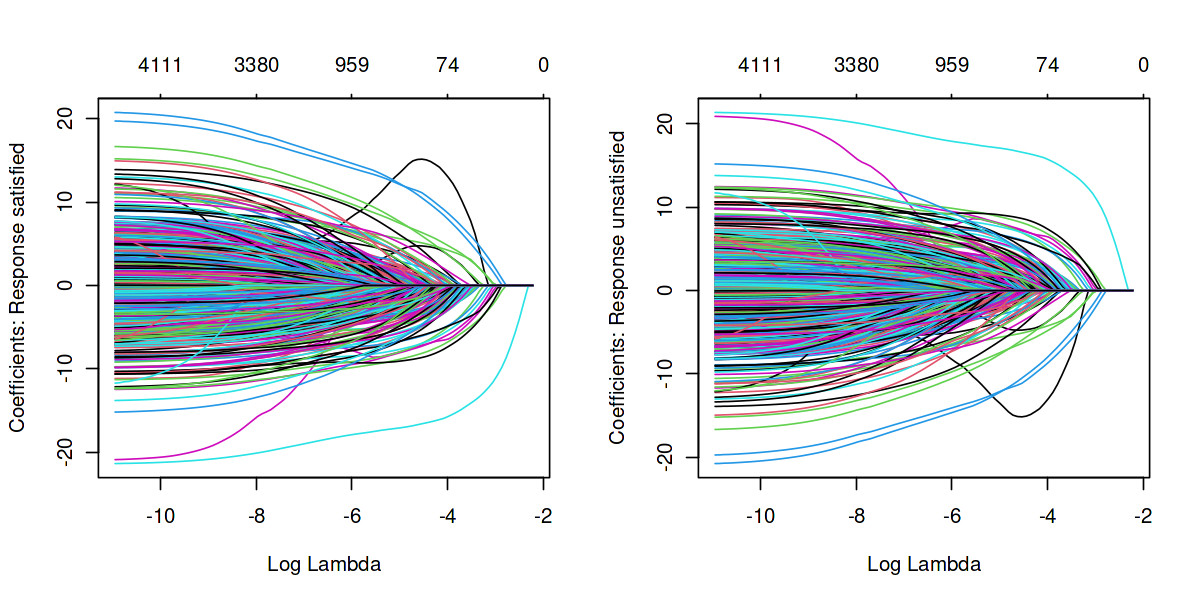

In [32]:
# lasso fit
lassofit = glmnet::glmnet(sparse_train_x, train_y, family="multinomial")

# Make larger plot in Kaggle
options(repr.plot.width=10, repr.plot.height=5)

# Arrange 3 cases in 4x4 layout
layout(matrix(1:2,1))
plot(lassofit, 'lambda')

In these plots it is clear that the first coefficients start to deviate from zero around $\log\lambda = -2$. We would probably nead quite some features to have a good working model but don't want to overfit the data. We thus select two tuning parameters to compare. The first is $\log\lambda = -4$. This values seems to include some features but not that many. Second, we use $\log\lambda = -7$ to include more features. Now we perform the Lasso with Cross-Validiation to get a tuning parameter. 



Loaded glmnet 4.1-4



[1] 0.0007195175

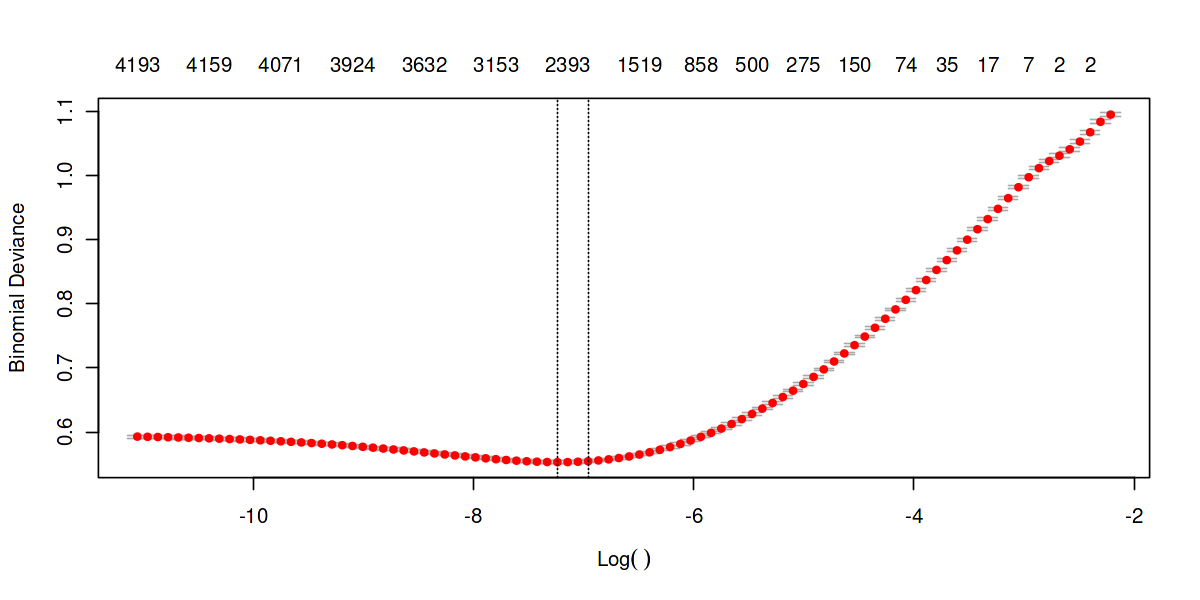

In [33]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4) 

# Cross-validate the lambda parameter
cv_fitlasso = glmnet::cv.glmnet(sparse_train_x, train_y, family = "binomial", 
                                parallel=TRUE)

#visually inspect cv fit lasso result 
cv_fitlasso$lambda.min 
plot(cv_fitlasso)

The $\lambda$ with the lowest minimum is sligtly above $\log -7$. Our handpicked $\lambda$ could thus perfrom quite well. 

## 5.1.2. Ridge regression


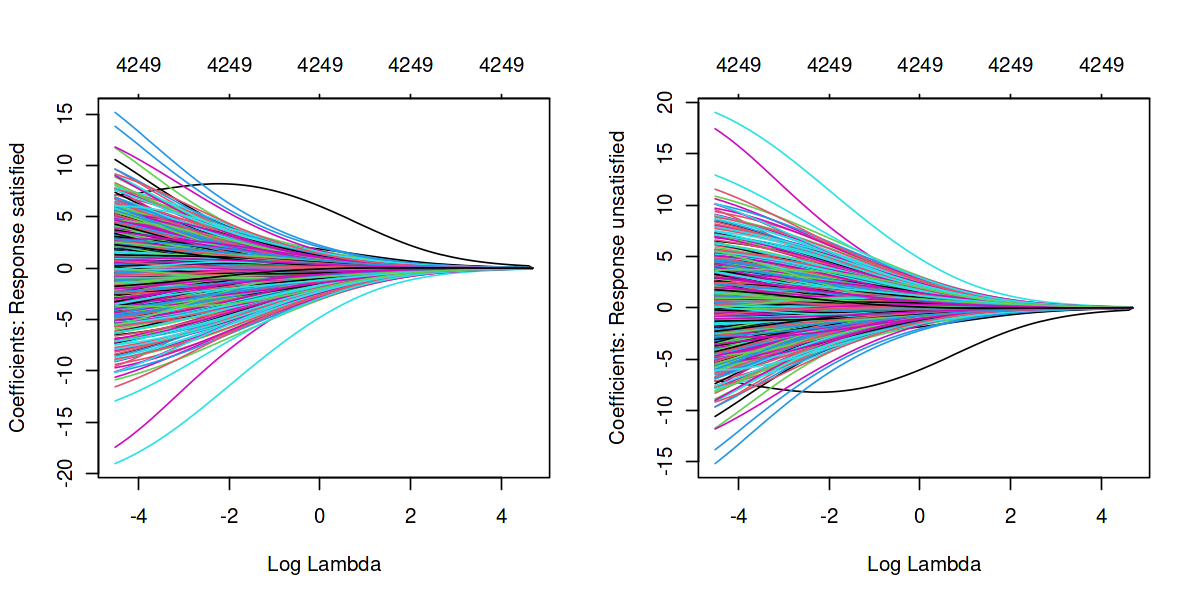

In [34]:
ridgefit = glmnet::glmnet(sparse_train_x, train_y, family="multinomial", 
                          alpha = 0)
options(repr.plot.width=10, repr.plot.height=5)
layout(matrix(1:2,1))
plot(ridgefit, 'lambda')

For the ridge regression, at $\log\lambda = 4$ the coefficients start to deviate from zero. We again select two tuning parameters, they are $\log\lambda = 1$ and $\log\lambda = -2$

[1] 0.0158663

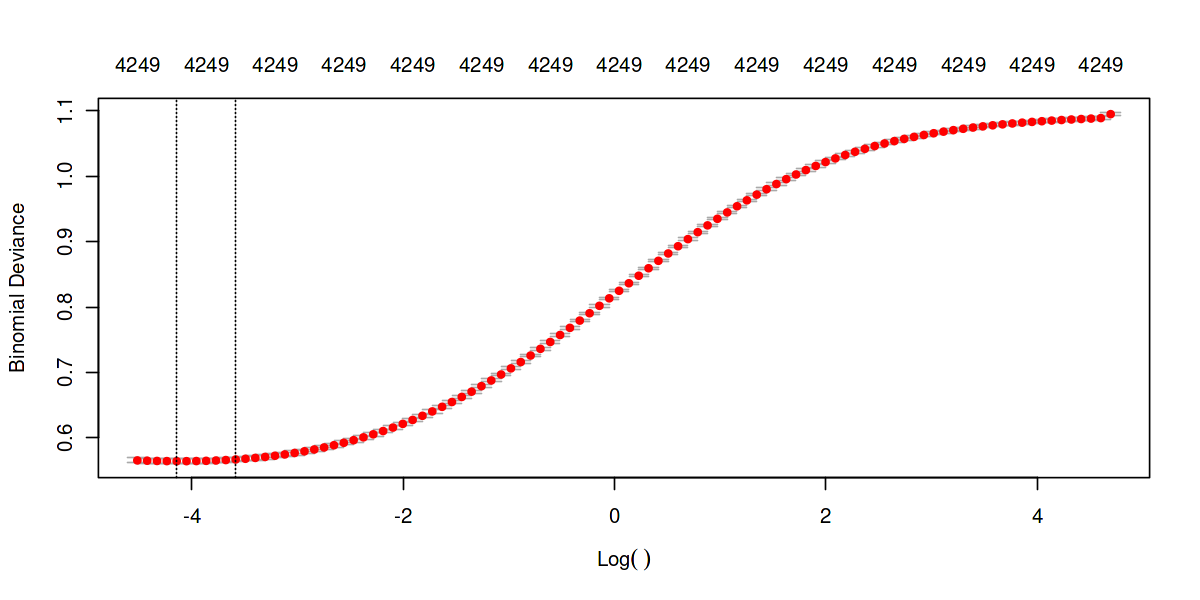

In [35]:
doMC::registerDoMC(cores = 4) 

# Cross-validate the lambda parameter
cv_fitridge = glmnet::cv.glmnet(sparse_train_x, train_y, family = "binomial", 
                                alpha = 0, parallel=TRUE)

cv_fitridge$lambda.min 
plot(cv_fitridge)


The $\lambda$ where the mimimum is for the ridge regression is around $\log -3.5$. This is lower than the handpicked values for $\lambda$ and we would thus expect quite worse performance. 

# 5.2 Model evaluation



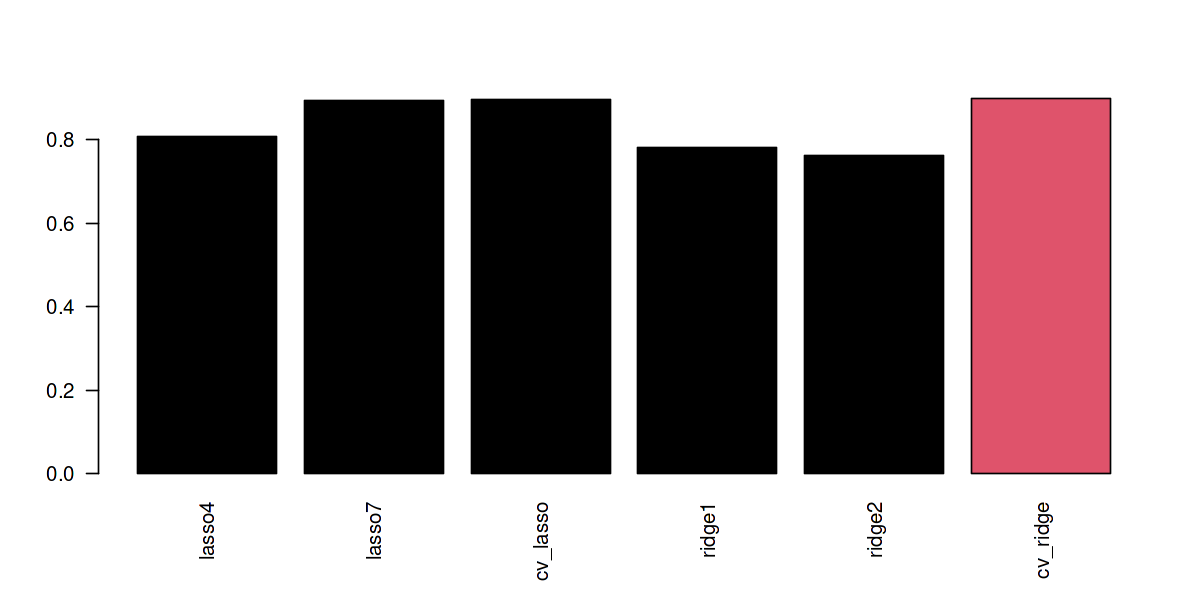

In [36]:
models = list(lasso4 =lassofit, lasso7 =lassofit, cv_lasso=cv_fitlasso, ridge1=ridgefit, ridge2=ridgefit, cv_ridge=cv_fitridge)
lambda = list(exp(-4), exp(-7), cv_fitlasso$lambda.min, exp(1), exp(2), cv_fitridge$lambda.min )

get_predict = function(fit, lambda){
  predict(fit, sparse_train_x, s= lambda, type='class') %>% 
    as.factor()
}

pred = mapply(get_predict, models, lambda)

mean_accuracy = apply(pred, 2, function(x) mean(x == train_y))
names(mean_accuracy) = names(models)
barplot(mean_accuracy, col = 1 + (mean_accuracy == max(mean_accuracy)), las=2)


As can be seen, for both the ridge regression and the lasso, the cross-validated model performed better than the manually selected tuning parameters. Therefore, from now on, we will not discuss the models with the manually selected $\lambda$. The ridge regression has slightly better accuracy than the lasso, but the difference is minimal, so they seem to perform similarly. 

In [37]:
cv_fitlasso2 = glmnet::cv.glmnet(sparse_train_x, train_y, family = "binomial", 
                                parallel=TRUE, type.measure = "class")
pred_lasso2 = predict(cv_fitlasso2, newx=sparse_train_x, s='lambda.min', type='class') %>% as.factor()
cv_fitridge2 = glmnet::cv.glmnet(sparse_train_x, train_y, family = "binomial", alpha = 0,
                                 parallel=TRUE, type.measure = "class")
pred_ridge2 = predict(cv_fitridge2, newx=sparse_train_x, s='lambda.min', type='class') %>% as.factor()

caret::confusionMatrix(pred_lasso2, train_y)
caret::confusionMatrix(pred_ridge2, train_y)



Confusion Matrix and Statistics

             Reference
Prediction    satisfied unsatisfied
  satisfied       67294        6688
  unsatisfied      2987       15149
                                         
               Accuracy : 0.895          
                 95% CI : (0.893, 0.8969)
    No Information Rate : 0.7629         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6916         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9575         
            Specificity : 0.6937         
         Pos Pred Value : 0.9096         
         Neg Pred Value : 0.8353         
             Prevalence : 0.7629         
         Detection Rate : 0.7305         
   Detection Prevalence : 0.8031         
      Balanced Accuracy : 0.8256         
                                         
       'Positive' Class : satisfied   

Confusion Matrix and Statistics

             Reference
Prediction    satisfied unsatisfied
  satisfied       67319        6223
  unsatisfied      2962       15614
                                          
               Accuracy : 0.9003          
                 95% CI : (0.8983, 0.9022)
    No Information Rate : 0.7629          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7094          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9579          
            Specificity : 0.7150          
         Pos Pred Value : 0.9154          
         Neg Pred Value : 0.8405          
             Prevalence : 0.7629          
         Detection Rate : 0.7308          
   Detection Prevalence : 0.7983          
      Balanced Accuracy : 0.8364          
                                          
       'Positive' C

The confussion matrixes show that the sensitifity of both the ridge regression and the lasso are above 90%, but the specitifity is consideratly lower around 70%. We now look at what words are importent for both 


In [38]:
varImp_top20 = . %>% 
  coef() %>%          # extract the raw coefficients
  abs() %>%           # take their absolute value
  as.matrix() %>% 
  as.data.frame() %>% # put them in a data frame
  rownames_to_column('coefficient') %>% 
  slice(-1) %>%         # remove the '(Intercept)' line
  as_tibble() %>% 
  top_n(20, wt = s1)

varImp_top20(cv_fitlasso) %>% 
  full_join(varImp_top20(cv_fitridge), by = "coefficient") %>%
  rename(Lasso = "s1.x", Ridge = "s1.y")

coefficient,Lasso,Ridge
<chr>,<dbl>,<dbl>
but,20.92013,15.79661
not,37.89279,29.30388
perfect,25.10750,NA
poor,17.58856,13.63875
the,21.62793,22.67451
great,32.73979,18.33881
love,31.33572,16.44746
disappointed,21.12824,16.94444
return,18.58176,15.21588


Interestingly, the ridge regression and lasso result in quite some differences in what parameters are the most importent. The words that come out on top are mostly quite logical. It is not unsurprinsing that words like "waste" or "love" are good predectors for the rating of a review. 


# 6. Submitting your predictions

A sample file is provided to make sure that you predict the right cases and submit your predictions in the right format:

In [39]:
pred = predict(cv_fitlasso, sparse_test_x, s='lambda.min', type='response') 
length(pred)

[1] 30000

In [40]:
# format submission file 
predictions = as_tibble(pred, rownames = "Id") %>% 
    rename(Prediction = 'lambda.min') %>% 
    select(Id, Prediction) %>% 
    mutate(Id = as.numeric(Id)) %>% 
    arrange(Id) %>%
    # we discovered that our model is prediction probability of the unsatisfied class 
    mutate(Prediction = 1-Prediction)

head(predictions)


Id,Prediction
<dbl>,<dbl>
3,0.9952676
5,0.9539351
8,0.9893122
14,0.7900330
20,0.8979503
22,0.4728787


In [41]:
# Write your predictions data frame to file
write_csv(predictions, file="predictions.csv")

__Feature creation__

- Bag of words (L)
- Ngram corrected sentiment (L)
- Num of stop words (L) 
- Total number of words (L) 
- Adjectives (L) 
- Join to spare matrix (L)

__Model fitting (cv)__  

- Multinomial logistic lasso, cv_lasso (L) 
- Ridge, cv_ridge (Z)

__Model evaluation/comparison__ (Z)

- Compare cross validation results from all fitted models 
- Output prediction 
- Prediction 
